# SVM Modeling

In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_recall_fscore_support, make_scorer, fbeta_score, RocCurveDisplay, DetCurveDisplay, ConfusionMatrixDisplay
from sklearn.decomposition import PCA

np.random.seed(1000)

## Load Data

In [99]:
def read_dataset(name):
  df_train = pd.read_csv(f"../data/modeling/data_{name}_train.csv")
  df_test = pd.read_csv(f"../data/modeling/data_{name}_test.csv")

  X_train = df_train.drop(columns="Abnormal")
  X_test = df_test.drop(columns="Abnormal")
  y_train = df_train.Abnormal
  y_test = df_test.Abnormal

  return X_train, X_test, y_train, y_test

X_1da_train, X_1da_test, y_train, y_test = read_dataset("1da")
X_reduced_train, X_reduced_test, _, _ = read_dataset("reduced")
X_expanded_train, X_expanded_test, _, _ = read_dataset("expanded")

In [100]:
print(PCA().fit(StandardScaler().fit_transform(X_1da_train)).explained_variance_ratio_.cumsum())
print(PCA().fit(StandardScaler().fit_transform(X_reduced_train)).explained_variance_ratio_.cumsum())
print(PCA().fit(StandardScaler().fit_transform(X_expanded_train)).explained_variance_ratio_.cumsum())

[0.39700735 0.63287608 0.74650163 0.81383242 0.87050126 0.91141341
 0.94993668 0.97485904 0.99264176 0.99879509 0.99945779 1.
 1.         1.         1.         1.         1.        ]
[0.32791273 0.51208771 0.6540545  0.75887394 0.84755584 0.91181186
 0.95587616 0.98700267 1.         1.        ]
[0.31920099 0.50542221 0.64004963 0.73758345 0.80557019 0.86127851
 0.90377085 0.92985204 0.94274255 0.95351873 0.96139636 0.96673013
 0.97118342 0.97523752 0.97880062 0.98191657 0.98471403 0.98708323
 0.98909252 0.99086671 0.9924575  0.99349598 0.99447301 0.99533795
 0.99601222 0.99658622 0.99701223 0.99741953 0.99777589 0.99811357
 0.99839581 0.99861115 0.99882032 0.9990078  0.99917539 0.99930616
 0.99942135 0.99952421 0.99961496 0.99969725 0.99975768 0.99981002
 0.99985646 0.99990023 0.99993251 0.99995385 0.99997388 0.99998558
 0.99998963 0.99999327 0.99999659 0.99999895 1.         1.
 1.         1.         1.         1.         1.         1.        ]


## Model Configuration

In [101]:
train_features = {
  "svm_1da": X_1da_train,
  "svm_red": X_reduced_train,
  "svm_exp": X_expanded_train,
  "svm_pca_1da": X_1da_train,
  "svm_pca_red": X_reduced_train,
  "svm_pca_exp": X_expanded_train,
}

test_features = {
  "svm_1da": X_1da_test,
  "svm_red": X_reduced_test,
  "svm_exp": X_expanded_test,
  "svm_pca_1da": X_1da_test,
  "svm_pca_red": X_reduced_test,
  "svm_pca_exp": X_expanded_test,
}

def make_svm_config(pca_n_components = None):
  config = {
    "clf": SVC(kernel="linear"),
    "param_grid": {
      "clf__C": [x for x in np.logspace(-7, -1, 3)]
    },
  }

  if pca_n_components is not None:
    config["param_grid"]["pca__n_components"] = pca_n_components
  return config

model_configs = {
  "svm_1da": make_svm_config(),
  "svm_red": make_svm_config(),
  "svm_exp": make_svm_config(),
  "svm_pca_1da": make_svm_config([6, 7, 8, 9, 10]),
  "svm_pca_red": make_svm_config([6, 7, 8]),
  "svm_pca_exp": make_svm_config([6, 8, 10, 12])
}

## Training

In [102]:
def perform_grid_search_fit(model_config, X_fit, y_fit):
  clf = model_config["clf"]
  param_grid = model_config["param_grid"]

  pipe_steps = [
    ("scaler", StandardScaler()),
    ("clf", clf)
  ]

  if "pca" in name:
    pipe_steps.insert(1, ("pca", PCA()))

  pipe = Pipeline(pipe_steps)
  kf = StratifiedKFold(n_splits=10)
  search = GridSearchCV(pipe, param_grid, cv=kf, scoring=make_scorer(fbeta_score, beta=2), n_jobs=-1, refit=True, verbose=3)
  search.fit(X_fit, y_fit)

  return (search.best_estimator_, search.best_params_)

best_models = {}
for name, model_config in model_configs.items():
  X_train = train_features[name]
  best_model, best_params = perform_grid_search_fit(model_config, X_train, y_train)
  print(f"Best params for model {name}: {best_params}")
  best_models[name] = {
    "model": best_model,
    "params": best_params
  }

Fitting 10 folds for each of 3 candidates, totalling 30 fits


Best params for model svm_1da: {'clf__C': 0.1}
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Best params for model svm_red: {'clf__C': 0.1}
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Best params for model svm_exp: {'clf__C': 0.1}
Fitting 10 folds for each of 15 candidates, totalling 150 fits
Best params for model svm_pca_1da: {'clf__C': 0.1, 'pca__n_components': 8}
Fitting 10 folds for each of 9 candidates, totalling 90 fits
Best params for model svm_pca_red: {'clf__C': 0.1, 'pca__n_components': 8}
Fitting 10 folds for each of 12 candidates, totalling 120 fits
Best params for model svm_pca_exp: {'clf__C': 0.1, 'pca__n_components': 12}


## Fitted Coefficients

In [103]:
betas_df = pd.DataFrame(index=X_expanded_train.columns)
for name, best_model in best_models.items():
  mod = best_model["model"]
  params = best_model["params"]
  X_train = train_features[name]

  if "pca" not in name:
    betas = mod.named_steps["clf"].coef_
    betas = pd.Series(betas[0], index=X_train.columns, name=name)
    betas_df = betas_df.merge(betas, how="left", left_index=True, right_index=True)
display(betas_df)

,svm_1da,svm_red,svm_exp
ACWO_1,0.104822,0.178040,0.993617
ACWO_2,NaN,NaN,-0.312487
ACWO_3,NaN,NaN,-0.599508
ACWO_4,NaN,NaN,-0.071077
ACWO_5,NaN,NaN,-1.103530
ACWO_6,NaN,NaN,1.069217
ADMO_1,0.093131,-0.024568,0.022659
ADMO_2,NaN,NaN,0.470708
ADMO_3,NaN,NaN,-0.527023
ADMO_4,NaN,NaN,-0.210030


## Train Evaluation

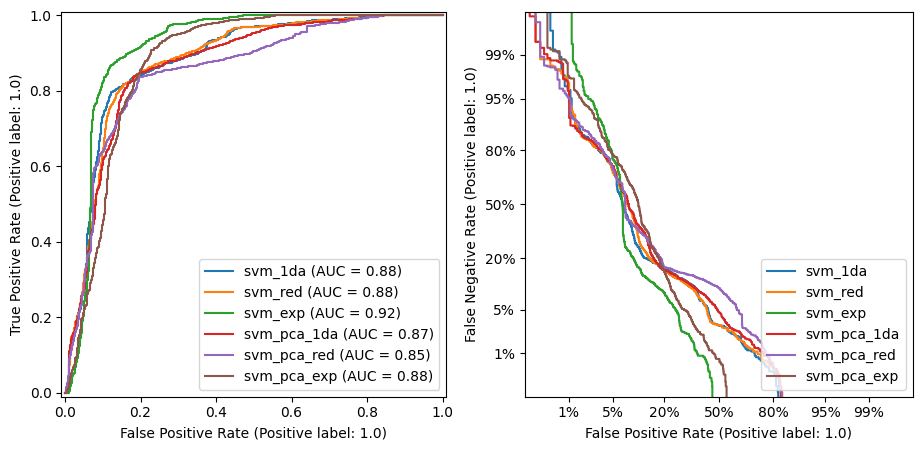

In [104]:
fig, [ax_roc, ax_det] = plt.subplots(1, 2, figsize=(11, 5))

for name, best_model in best_models.items():
  mod = best_model["model"]
  params = best_model["params"]
  X_train = train_features[name]
 
  RocCurveDisplay.from_estimator(mod, X_train, y_train, ax=ax_roc, name=name)
  DetCurveDisplay.from_estimator(mod, X_train, y_train, ax=ax_det, name=name)

## Test Evaluation

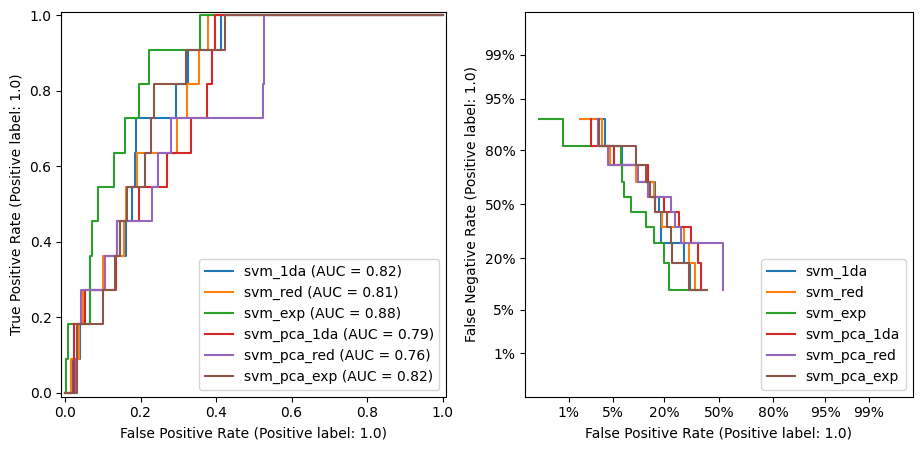

In [105]:
fig, [ax_roc, ax_det] = plt.subplots(1, 2, figsize=(11, 5))

for name, best_model in best_models.items():
  mod = best_model["model"]
  params = best_model["params"]
  X_test = test_features[name]
 
  RocCurveDisplay.from_estimator(mod, X_test, y_test, ax=ax_roc, name=name)
  DetCurveDisplay.from_estimator(mod, X_test, y_test, ax=ax_det, name=name)

svm_1da - precision: 0.05096, recall: 0.7273, f2: 0.199
svm_red - precision: 0.04459, recall: 0.6364, f2: 0.1741
svm_exp - precision: 0.06087, recall: 0.6364, f2: 0.2201
svm_pca_1da - precision: 0.03521, recall: 0.4545, f2: 0.1344
svm_pca_red - precision: 0.03623, recall: 0.4545, f2: 0.1374
svm_pca_exp - precision: 0.04787, recall: 0.8182, f2: 0.194


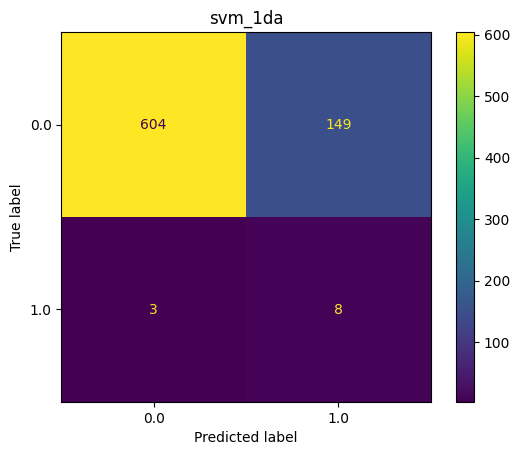

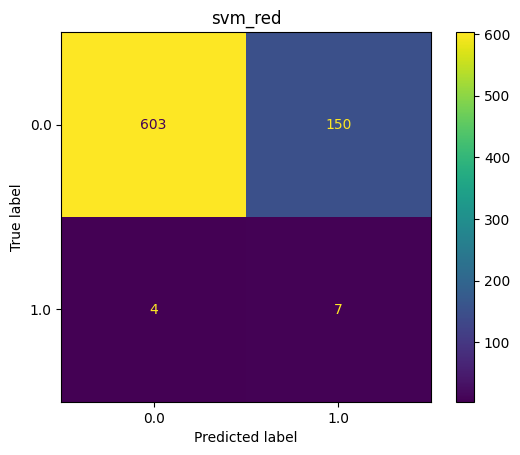

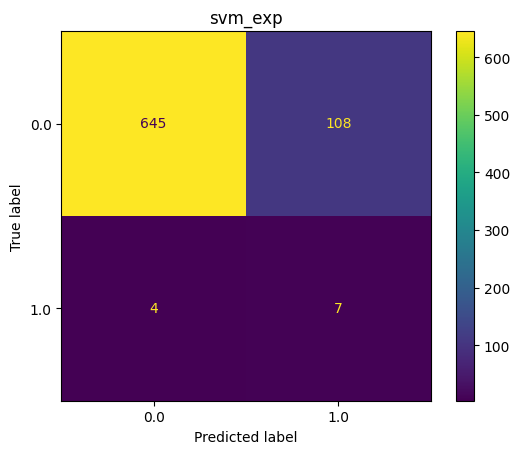

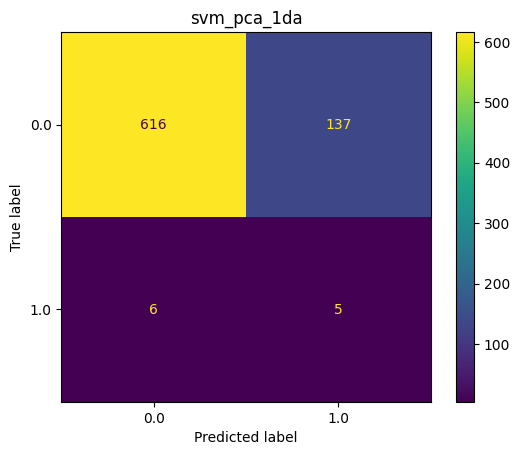

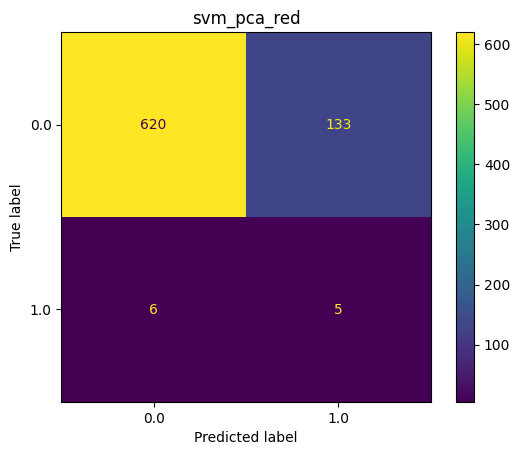

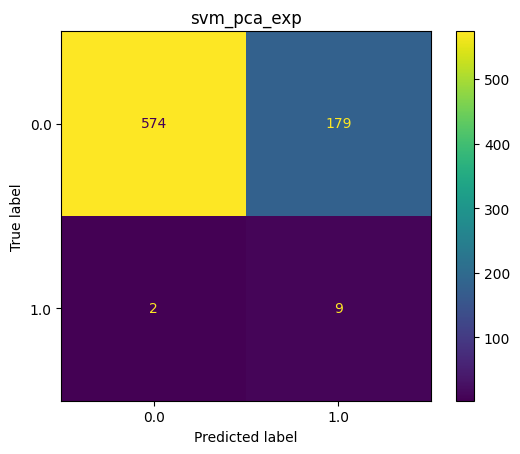

In [106]:
for name, best_model in best_models.items():
  mod = best_model["model"]
  X_test = test_features[name]

  test_pred = mod.predict(X_test)

  p, r, f2, supp = precision_recall_fscore_support(y_test, test_pred, average="binary", beta=2, pos_label=1.0, zero_division=0)
  print(f"{name} - precision: {p:.4}, recall: {r:.4}, f2: {f2:.4}")

  disp = ConfusionMatrixDisplay.from_predictions(y_test, test_pred)
  disp.ax_.set_title(name)